In [1]:
!pip install -U ultralytics
import kagglehub
path = kagglehub.dataset_download("anasmohammedtahir/covidqu")

print("Path to dataset files:", path)

!apt-get install tree
!tree -L 5 /root/.cache/kagglehub/datasets/anasmohammedtahir/covidqu/versions/7

import os

for root, dirs, files in os.walk(path):
    print(root, " | files:", len(files))



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.7 MB/s eta 0:00:00
Using Colab cache for faster access to the 'covidqu' dataset.
Path to dataset files: /kaggle/input/covidqu
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (841 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
/root/.cache/kagglehub/datasets/anasmohammedtahir/covidqu/versions/7  [error opening dir]

0 directories,

In [6]:
DATASET_ROOT = "/kaggle/input/covidqu"
INFECTION_ROOT = os.path.join(
    DATASET_ROOT,
    "Infection Segmentation Data",
    "Infection Segmentation Data"
)

YOLO_ROOT = "/content/yolo_covid"

print(INFECTION_ROOT)

/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data


In [7]:
for p in [
    "images/train", "images/val", "images/test",
    "labels/train", "labels/val", "labels/test"
]:
    os.makedirs(os.path.join(YOLO_ROOT, p), exist_ok=True)


In [8]:
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import shutil

CLASS_ID = 0   #infection

def mask_to_polygons(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polys = []
    for c in contours:
        if cv2.contourArea(c) < 100:
            continue
        c = c.squeeze()
        if len(c.shape) == 2:
            polys.append(c)
    return polys

def convert_split(split):
    out_img_dir = os.path.join(YOLO_ROOT, "images", split.lower())
    out_lbl_dir = os.path.join(YOLO_ROOT, "labels", split.lower())

    classes = ["COVID-19", "Non-COVID", "Normal"]

    for cls in classes:
        img_dir  = os.path.join(INFECTION_ROOT, split, cls, "images")
        mask_dir = os.path.join(INFECTION_ROOT, split, cls, "infection masks")
        imgs = sorted(glob(img_dir + "/*"))
        masks = sorted(glob(mask_dir + "/*"))

        for img_path, mask_path in tqdm(zip(imgs, masks), total=len(imgs)):
            name = os.path.basename(img_path)
            shutil.copy(img_path, os.path.join(out_img_dir, name))
            mask = cv2.imread(mask_path, 0)
            h, w = mask.shape
            _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

            polys = mask_to_polygons(mask)

            label_path = os.path.join(
                out_lbl_dir,
                os.path.splitext(name)[0] + ".txt"
            )

            with open(label_path, "w") as f:
                for poly in polys:
                    norm = []
                    for x, y in poly:
                        norm.append(x / w)
                        norm.append(y / h)
                    norm = " ".join([f"{v:.6f}" for v in norm])
                    f.write(f"{CLASS_ID} {norm}\n")
convert_split("Train")
convert_split("Val")
convert_split("Test")

100%|██████████| 291/291 [00:04<00:00, 61.45it/s]


In [9]:
YOLO_ROOT = "/content/yolo_covid"
os.makedirs(YOLO_ROOT, exist_ok=True)
yaml_path = os.path.join(YOLO_ROOT, "data.yaml")

yaml_text = f"""
path: {YOLO_ROOT}
train: images/train
val: images/val
test: images/test

nc: 1
names: ["infection"]
"""

with open(yaml_path, "w") as f:
    f.write(yaml_text.strip())

print("Created:", yaml_path)


Created: /content/yolo_covid/data.yaml


In [11]:
from ultralytics import YOLO
model = YOLO("yolov8n-seg.pt")
model.train(
    data="/content/yolo_covid/data.yaml",
    epochs=20,
    imgsz=512,
    batch=16,
    device=0,
    workers=4
)


Ultralytics 8.4.10 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_covid/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b3d943f0b00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 


0: 512x512 3 infections, 15.8ms
1: 512x512 (no detections), 15.8ms
2: 512x512 (no detections), 15.8ms
Speed: 1.7ms preprocess, 15.8ms inference, 3.4ms postprocess per image at shape (1, 3, 512, 512)


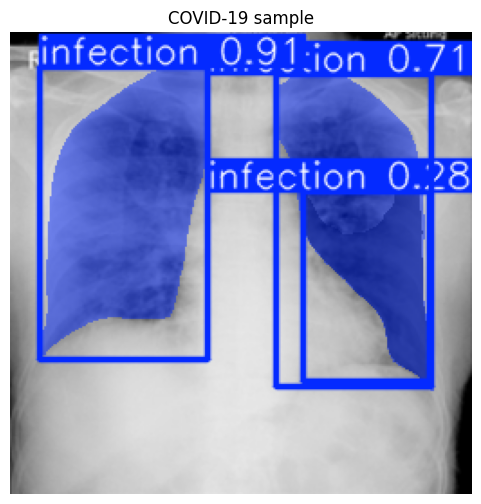

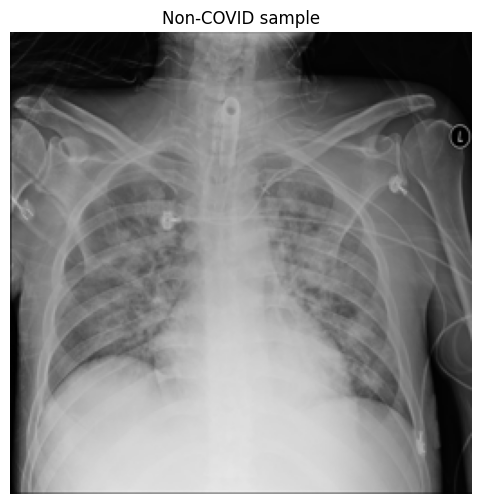

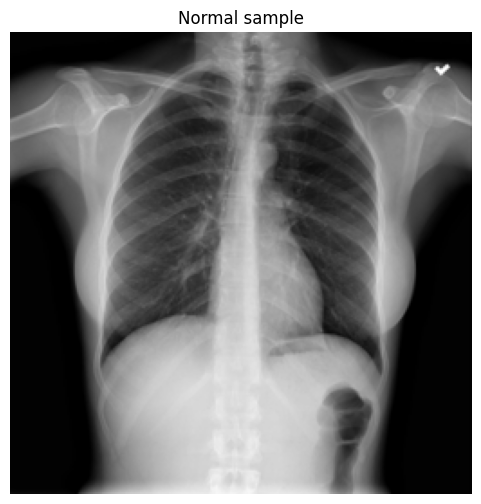

In [14]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt

model = YOLO("/content/runs/segment/train2/weights/best.pt")

test_images = [
    os.path.join(INFECTION_ROOT, "Test", "COVID-19", "images",
                 os.listdir(os.path.join(INFECTION_ROOT, "Test", "COVID-19", "images"))[0]),

    os.path.join(INFECTION_ROOT, "Test", "Non-COVID", "images",
                 os.listdir(os.path.join(INFECTION_ROOT, "Test", "Non-COVID", "images"))[0]),

    os.path.join(INFECTION_ROOT, "Test", "Normal", "images",
                 os.listdir(os.path.join(INFECTION_ROOT, "Test", "Normal", "images"))[0]),
]

results = model(test_images, conf=0.25)

for i, r in enumerate(results):
    img = r.plot()
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(["COVID-19 sample", "Non-COVID sample", "Normal sample"][i])
    plt.axis("off")
    plt.show()



In [17]:
import glob
runs = sorted(glob.glob("runs/segment/train*"))
runs[-1]
import pandas as pd, matplotlib.pyplot as plt
run_dir = sorted(glob.glob("runs/segment/train*"))[-1]
df = pd.read_csv(f"{run_dir}/results.csv")
df.columns

model = YOLO(sorted(glob.glob("runs/segment/train2/weights/best.pt"))[-1])
metrics = model.val(
    data="/content/yolo_covid/data.yaml",
    split="test",
    imgsz=512
)


Ultralytics 8.4.10 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 86 layers, 3,258,259 parameters, 0 gradients, 11.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5.1±2.6 MB/s, size: 27.9 KB)
val: Scanning /content/yolo_covid/labels/test... 1166 images, 583 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1166/1166 1.6Kit/s 0.7s
val: New cache created: /content/yolo_covid/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 73/73 6.2it/s 11.7s
                   all       1166       1156      0.758      0.665       0.75      0.519      0.754      0.674      0.749      0.483
Speed: 1.2ms preprocess, 3.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/runs/segment/val


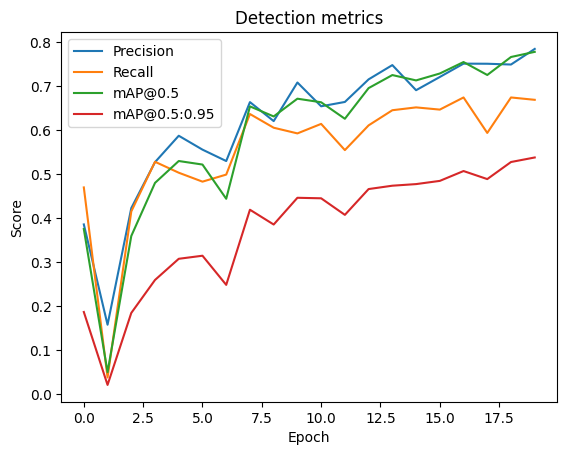

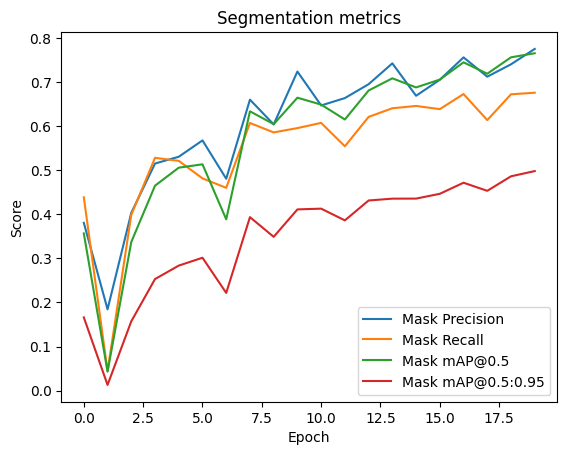

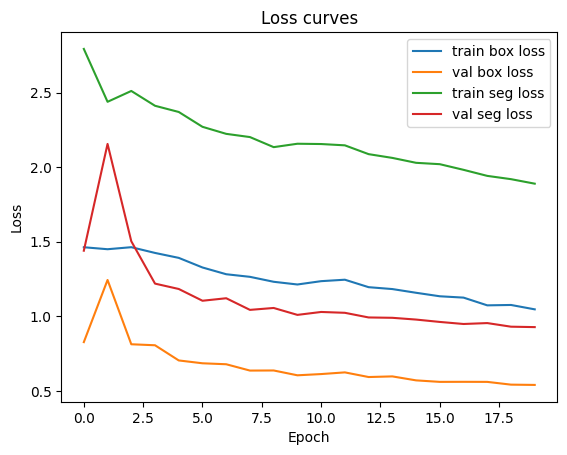

In [18]:
plt.figure()
plt.plot(df["metrics/precision(B)"], label="Precision")
plt.plot(df["metrics/recall(B)"], label="Recall")
plt.plot(df["metrics/mAP50(B)"], label="mAP@0.5")
plt.plot(df["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Detection metrics")
plt.show()

plt.figure()
plt.plot(df["metrics/precision(M)"], label="Mask Precision")
plt.plot(df["metrics/recall(M)"], label="Mask Recall")
plt.plot(df["metrics/mAP50(M)"], label="Mask mAP@0.5")
plt.plot(df["metrics/mAP50-95(M)"], label="Mask mAP@0.5:0.95")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Segmentation metrics")
plt.show()

plt.figure()
plt.plot(df["train/box_loss"], label="train box loss")
plt.plot(df["val/box_loss"], label="val box loss")
plt.plot(df["train/seg_loss"], label="train seg loss")
plt.plot(df["val/seg_loss"], label="val seg loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss curvess")
plt.show()
